In [41]:
!pip install lime
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from lime.lime_tabular import LimeTabularExplainer



# =========================================
# Load and Preprocess Data
# =========================================

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_path = '/content/drive/My Drive/ML2/X_train.csv'
df = pd.read_csv(file_path)

In [6]:
print(df.head())

              business_id                         name  \
0  p3KoL5eUlxgWqIWRdV_wBw                  Regal Nails   
1  GtC_ResrQIJid_WKLtrZeQ  Founding Fathers Outfitters   
2  _cEqBObvQCg8cRPMoZv21A        Veronica's Restaurant   
3  VayJyqAwLdMBt9HAINkxrA            Jazmin Restaurant   
4  sZAPMC8zviqb6sFHxsN5SQ                  Regis Salon   

                        address          city state postal_code   latitude  \
0             8280 N Cortaro Rd        Tucson    AZ       85743  32.356262   
1               9280 Ridge Pike  Philadelphia    PA       19128  40.074787   
2               26 S Haddon Ave   Haddonfield    NJ       08033  39.897403   
3                2013 N 63rd St  Philadelphia    PA       19151  39.986085   
4  1800 Galleria Blvd, Ste 2145      Franklin    TN       37067  35.957356   

    longitude  stars  review_count  ...  GoodForKids RestaurantsGoodForGroups  \
0 -111.089446    2.5             8  ...          NaN                      NaN   
1  -75.244511    4.5

In [7]:
import numpy as np
import pandas as pd

def preprocess_dataframe(df):
    # Drop rows with missing values
    # df_clean = df.dropna().copy()
    df_clean = df.copy()

    print(f"first --> + {df_clean.shape}")

    # List of columns to convert
    columns_to_convert = [
        'BusinessAcceptsCreditCards', 'RestaurantsPriceRange2', 'RestaurantsTakeOut',
        'RestaurantsDelivery', 'Caters', 'WiFi', 'WheelchairAccessible',
        'OutdoorSeating', 'HasTV', 'RestaurantsReservations', 'GoodForKids',
        'RestaurantsGoodForGroups'
    ]

    # Convert TRUE/FALSE to 1/0 and handle missing or unexpected values
    for col in columns_to_convert:
        if col in df_clean.columns:
            # Replace various representations of TRUE/FALSE with 1/0
            df_clean[col] = df_clean[col].replace({
                "TRUE": 1, "FALSE": 0,
                "True": 1, "False": 0,
                True: 1, False: 0
            })
            # Replace empty strings, 'nan', and NaN with 0
            df_clean[col] = df_clean[col].replace({"": 0, "nan": 0, np.nan: 0})
            # Explicitly cast to integer type
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce').fillna(0).astype(int)

    print(f"second --> + {df_clean.shape}")

    # Handle the WiFi column with specific mapping
    if 'WiFi' in df_clean.columns:
        # Convert all values to strings
        df_clean['WiFi'] = df_clean['WiFi'].astype(str)
        # Clean values by removing prefixes and quotes
        df_clean['WiFi'] = df_clean['WiFi'].str.replace(r"^u'|^'|'$", "", regex=True)
        # Map values to integers
        wifi_mapping = {
            '0': 0,
            'no': 0,
            'free': 1,
            'paid': 2
        }
        df_clean['WiFi'] = df_clean['WiFi'].replace(wifi_mapping)
        # Replace unexpected values or NaN with 0
        df_clean['WiFi'] = pd.to_numeric(df_clean['WiFi'], errors='coerce').fillna(0).astype(int)

    print(f"third --> + {df_clean.shape}")

    # Drop columns that are non-numeric or irrelevant for IsolationForest
    columns_to_drop = ['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'categories']
    if any(col in df_clean.columns for col in columns_to_drop):
        df_clean = df_clean.drop(columns=[col for col in columns_to_drop if col in df_clean.columns])

    print(f"fourth --> + {df_clean.shape}")

    # Ensure only numeric columns are passed to the model
    df_numeric = df_clean.select_dtypes(include=[np.number])

    print(f"fifth --> + {df_clean.shape}")

    # Check for missing values and fill them
    df_numeric = df_numeric.fillna(0)

    print(f"sixth --> + {df_clean.shape}")

    return df_numeric


In [8]:
# Drop rows with missing values
df_clean = df.dropna().copy()

In [9]:
# Example list of columns that need converting
columns_to_convert = [
    'BusinessAcceptsCreditCards', 'RestaurantsPriceRange2', 'RestaurantsTakeOut',
    'RestaurantsDelivery', 'Caters', 'WiFi', 'WheelchairAccessible',
    'OutdoorSeating', 'HasTV', 'RestaurantsReservations', 'GoodForKids',
    'RestaurantsGoodForGroups'
]

In [10]:
print(df['WiFi'].unique())

[nan "u'no'" "'no'" "u'free'" "'free'" "'paid'" "u'paid'"]


In [14]:
# Convert TRUE/FALSE to 1/0 and handle missing or unexpected values
for col in columns_to_convert:
    if col in df.columns:
        # Replace various representations of TRUE/FALSE with 1/0
        df[col] = df[col].replace({
            "TRUE": 1, "FALSE": 0,  # String representations
            "True": 1, "False": 0,  # Other casing of strings
            True: 1, False: 0       # Boolean values
        })

        # Replace empty strings, 'nan' (as string), and NaN with 0
        df[col] = df[col].replace({"": 0, "nan": 0, np.nan: 0})

        # Explicitly cast to integer type
        df[col] = df[col].astype(int)

# Handle the WiFi column with specific mapping
    if 'WiFi' in df.columns:
        # Convert all values to strings
        df['WiFi'] = df['WiFi'].astype(str)

        # Clean values by removing prefixes like "u'" and surrounding quotes
        df['WiFi'] = df['WiFi'].str.replace(r"^u'|^'|'$", "", regex=True)

        # Map values to integers
        wifi_mapping = {
            '0': 0,    # Already numeric
            'no': 0,   # No WiFi
            'free': 1, # Free WiFi
            'paid': 2  # Paid WiFi
        }
        df['WiFi'] = df['WiFi'].replace(wifi_mapping)

        df['WiFi'] = pd.to_numeric(df['WiFi'], errors='coerce').fillna(0).astype(int)



#============================================================
# Load Preprocessed Data
#============================================================

In [15]:
# Adjust the file paths as necessary.
X_test = pd.read_csv('/content/drive/My Drive/ML2/X_test.csv')
Y_train = pd.read_csv('/content/drive/My Drive/ML2/Y_train.csv').squeeze()  # Convert DataFrame to Series
Y_test = pd.read_csv('/content/drive/My Drive/ML2/Y_test.csv').squeeze()

In [16]:
X_test.shape

(30070, 32)

In [17]:
# Ensure Y is integer type
Y_train = Y_train.astype(int)
Y_test = Y_test.astype(int)

In [18]:
# Drop columns that are non-numeric or irrelevant for IsolationForest
columns_to_drop = ['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'categories']
if any(col in df.columns for col in columns_to_drop):
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])


In [19]:
# Ensure only numeric columns are passed to the model
df_numeric = df.select_dtypes(include=[np.number])

In [20]:
# Check for missing values and fill them (IsolationForest does not handle NaN)
df_numeric = df_numeric.fillna(0)


#============================================================
# Determine contamination
#============================================================

# Contamination should reflect the fraction of anomalies in the training data.


In [21]:
contamination_fraction = min(0.5, Y_train.mean())  # Ensure it's within the valid range
print(f"Estimated contamination fraction (anomaly proportion): {contamination_fraction}")

Estimated contamination fraction (anomaly proportion): 0.5


In [22]:
#============================================================
# Initialize and Fit the Isolation Forest
#============================================================

In [24]:
# Fit the model on the training set
iso_forest.fit(df_numeric)

IsolationForest(random_state=42)

In [25]:
# If predicting, ensure test data is also numeric and cleaned in the same way
predictions = iso_forest.predict(df_numeric)

In [26]:
# Convert predictions from {-1, 1} to {1, 0}
predictions = (predictions == -1).astype(int)

In [27]:
print("Predictions:")
print(predictions)

Predictions:
[0 0 1 ... 0 0 0]


# ============================================================
# Function to Train and Evaluate Isolation Forest
# ============================================================

In [28]:
def train_and_evaluate_iso_forest(X_train, X_test, Y_train, Y_test, contamination):
    print(f"\nTraining Isolation Forest with contamination={contamination}")

    # Measure training time for the Isolation Forest model
    start_time = time.time()

    iso_forest = IsolationForest(
        n_estimators=100,
        contamination=contamination,
        random_state=42
    )
    # Fit the model
    iso_forest.fit(X_train)

    end_time = time.time()

    # Predict
    predictions = iso_forest.predict(X_test)
    predictions = (predictions == -1).astype(int)  # Convert {-1, 1} to {1, 0}

    # Evaluate
    cm = confusion_matrix(Y_test, predictions)
    auc = roc_auc_score(Y_test, predictions)
    report = classification_report(Y_test, predictions, digits=4)

    print("\nConfusion Matrix:")
    print(cm)
    print(f"AUC: {auc:.4f}")
    print("\nClassification Report:")
    print(report)
    # Calculate the training time
    train_time = end_time - start_time
    print(f"Training Time: {train_time} seconds")

    return iso_forest, predictions, auc, cm

# ============================================================
# Empirical Tuning: Run 3 Iterations
# ============================================================

In [29]:
results = []
contamination_values = [0.05, 0.1, 0.2]

In [30]:
# Pre process Y-train
X_test = preprocess_dataframe(X_test)

first --> + (30070, 32)
second --> + (30070, 32)


<ipython-input-7-08ca55341c5d>:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean[col] = df_clean[col].replace({
<ipython-input-7-08ca55341c5d>:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean[col] = df_clean[col].replace({
<ipython-input-7-08ca55341c5d>:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_down

third --> + (30070, 32)
fourth --> + (30070, 25)
fifth --> + (30070, 25)
sixth --> + (30070, 25)


<ipython-input-7-08ca55341c5d>:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean['WiFi'] = df_clean['WiFi'].replace(wifi_mapping)


In [31]:
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)
print("Y_train shape:", Y_train.shape)
print("df_numeric shape:", df_numeric.shape)

X_test shape: (30070, 24)
Y_test shape: (30070,)
Y_train shape: (120276,)
df_numeric shape: (120276, 24)


In [32]:
for iteration, contamination in enumerate(contamination_values, start=1):
    print(f"\n--- Iteration {iteration} ---")
    model, predictions, auc, cm = train_and_evaluate_iso_forest(df_numeric, X_test, Y_train, Y_test, contamination)
    results.append({'Iteration': iteration, 'Contamination': contamination, 'AUC': auc, 'Confusion_Matrix': cm})


--- Iteration 1 ---

Training Isolation Forest with contamination=0.05

Confusion Matrix:
[[13136   125]
 [15645  1164]]
AUC: 0.5299

Classification Report:
              precision    recall  f1-score   support

           0     0.4564    0.9906    0.6249     13261
           1     0.9030    0.0692    0.1286     16809

    accuracy                         0.4756     30070
   macro avg     0.6797    0.5299    0.3768     30070
weighted avg     0.7061    0.4756    0.3475     30070

Training Time: 1.204493761062622 seconds

--- Iteration 2 ---

Training Isolation Forest with contamination=0.1

Confusion Matrix:
[[13006   255]
 [14513  2296]]
AUC: 0.5587

Classification Report:
              precision    recall  f1-score   support

           0     0.4726    0.9808    0.6379     13261
           1     0.9000    0.1366    0.2372     16809

    accuracy                         0.5089     30070
   macro avg     0.6863    0.5587    0.4375     30070
weighted avg     0.7115    0.5089    0.4139  

# Get Train and TEST AUC Score

In [42]:
from sklearn.metrics import roc_auc_score

# Predictions for the training data
train_predictions = iso_forest.predict(df_numeric)
train_predictions = (train_predictions == -1).astype(int)  # Convert {-1, 1} to {1, 0}

# Training AUC
training_auc = roc_auc_score(Y_train, train_predictions)

# Predictions for the test data
test_predictions = iso_forest.predict(X_test)
test_predictions = (test_predictions == -1).astype(int)  # Convert {-1, 1} to {1, 0}

# Test AUC
test_auc = roc_auc_score(Y_test, test_predictions)

print(f"Training AUC: {training_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Training AUC: 0.7098
Test AUC: 0.7037


# ============================================================
# LIME for Interpretability
# ============================================================

In [33]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    training_data=df_numeric.values,
    feature_names=df_numeric.columns,
    mode='regression'  # Use regression mode
)

i = 0  # Index of the instance to explain
exp = explainer.explain_instance(
    X_test.iloc[i].values,
    model.decision_function,  # Use decision_function for IsolationForest
    num_features=10
)
exp.show_in_notebook()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


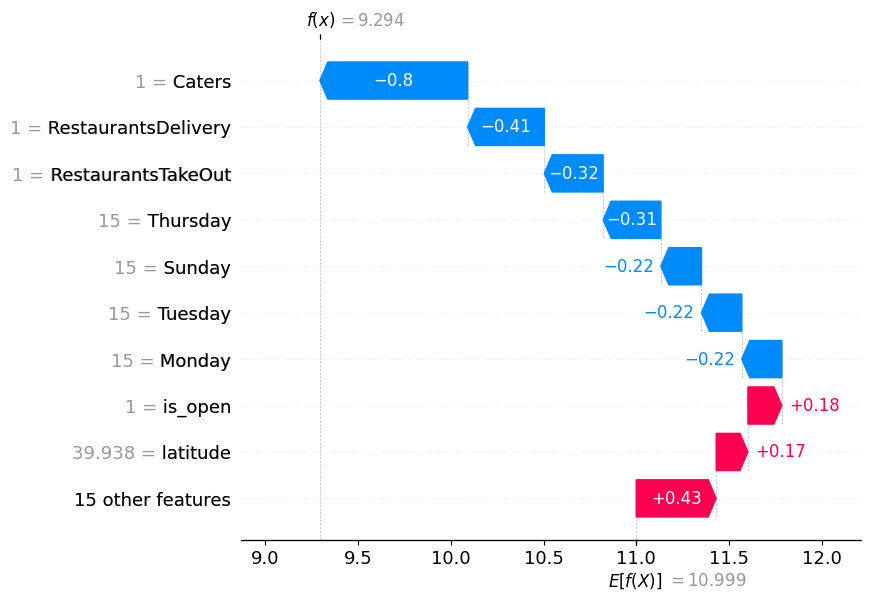

In [34]:
import shap

# Create a SHAP explainer
explainer = shap.Explainer(model, df_numeric)

# Explain a single instance
shap_values = explainer(X_test.iloc[i:i+1])

# Visualize the explanation
shap.plots.waterfall(shap_values[0])


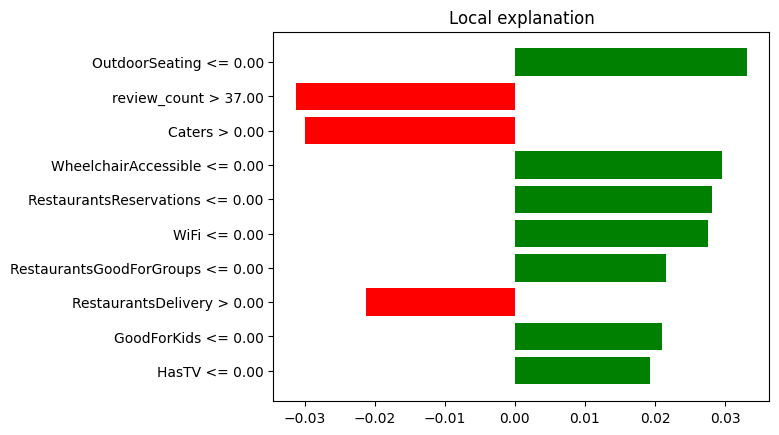

In [35]:
# Show the explanation
exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()
plt.show()

# ============================================================
# Summary of Results
# ============================================================

In [36]:
print("\n--- Summary of Results ---")
for result in results:
    print(f"Iteration {result['Iteration']}:")
    print(f"  Contamination: {result['Contamination']}")
    print(f"  AUC: {result['AUC']:.4f}")
    print(f"  Confusion Matrix:\n{result['Confusion_Matrix']}")


--- Summary of Results ---
Iteration 1:
  Contamination: 0.05
  AUC: 0.5299
  Confusion Matrix:
[[13136   125]
 [15645  1164]]
Iteration 2:
  Contamination: 0.1
  AUC: 0.5587
  Confusion Matrix:
[[13006   255]
 [14513  2296]]
Iteration 3:
  Contamination: 0.2
  AUC: 0.6217
  Confusion Matrix:
[[12665   596]
 [11963  4846]]


In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_auc(y_true, y_scores):
    # Compute False Positive Rate, True Positive Rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


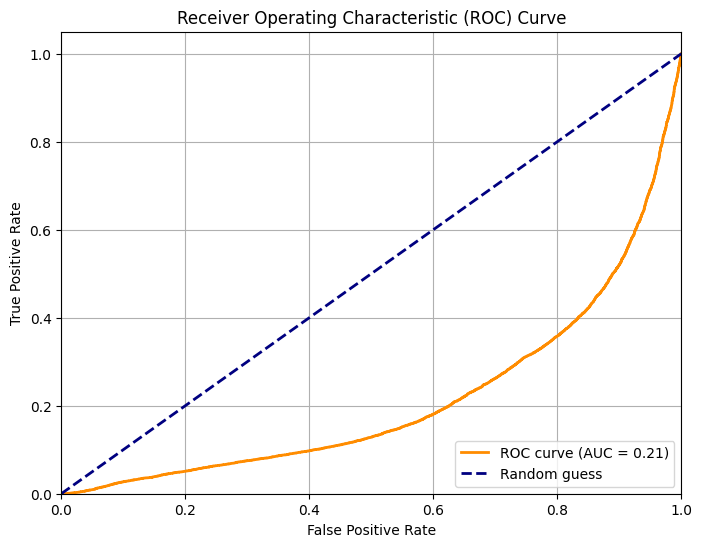

In [38]:
y_scores = model.decision_function(X_test)
plot_auc(Y_test, y_scores)

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import joblib

In [40]:
joblib.dump(model, 'model.pkl')

['model.pkl']

In [43]:
from nbconvert import HTMLExporter
import nbformat

In [44]:
# Path to your Jupyter Notebook file
input_file = 'isolation_forest_final.ipynb'
output_file = 'isolation_forest_final.html'

In [45]:
# Read the notebook
with open(input_file, 'r', encoding='utf-8') as file:
    notebook = nbformat.read(file, as_version=4)

# Export the notebook to HTML
html_exporter = HTMLExporter()
html_data, _ = html_exporter.from_notebook_node(notebook)

# Write the HTML data to a file
with open(output_file, 'w', encoding='utf-8') as file:
    file.write(html_data)

print(f"Notebook converted to HTML and saved as {output_file}")

FileNotFoundError: [Errno 2] No such file or directory: 'isolation_forest_final.ipynb'